<a href="https://colab.research.google.com/github/priyankabudavi/ML-Models/blob/main/INRIA_Unet_Priyanka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a UNET segmentation model, based on implementation in 'Segmentation Zoo'

https://github.com/dbuscombe-usgs/segmentation_zoo

Use Doodler to get labels for your images: https://github.com/dbuscombe-usgs/dash_doodler


In [35]:
# import the packages we need...
#first, the general stuff
import os
from os import getcwd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.7.0


In [36]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [37]:
#define the number of classes of the image...these are NOAA, so 

num_classes = 2

#this is a fn to make sure the labels go from 0- (num_classes-1)

def D_Filter(image):
    image[image>(num_classes-1)] = (num_classes-1)
    return image

In [38]:
#use imagemagick to turn the images into jpg and then split them into 1000x1000 images..


#mogrify -format jpg *.tif ../gt_jpg
#mogrify -crop 5x5@ +repage -path ../gt_jpg *.jpg

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
#build data flow routines, gettign the data from the files to the netowrk...

#first we decide how much of the data is training and how much is validation
split = 0.2

# Define dirs and files where the images and labels are.. Use doodler to get labels for your images!
image_dir = '/content/drive/MyDrive/updated_images/train/images' 
label_dir = '/content/drive/MyDrive/updated_images/train/labels'

#to make it deterministic, set the seed
SEED = 11

# We will use generators to flow the data.. for both training and validaton
# We also add some weak data-augmentation, and rescale the images here.
# note that we are using the generator to split the data. 
train_image_datagen = ImageDataGenerator(rescale =1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)

train_mask_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True,
                                   preprocessing_function = D_Filter,
                                   validation_split = split )

#set batch Size for the model — how many images go into the network at each
#step. 
batch_size = 10

#set Image size. We are using a UNET based on Segmentation Zoo.. 
# size choices are:
#
#(RGB so imshape is 3)
pix_dim_x = 1024
pix_dim_y = 1024
imsize = (pix_dim_x,pix_dim_y) 
imshape = (pix_dim_x,pix_dim_y,3)

masksize = (pix_dim_x,pix_dim_y) 


### This is where we set the generator to flow images from the folders into the 
#training. The is a generator for the image and another for the mask. And also 
# generators for the traing and val.. so 4 total.:

train_image_generator = train_image_datagen.flow_from_directory(image_dir,
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = imsize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    interpolation = "nearest",
                                                    subset ='training')

train_label_generator = train_mask_datagen.flow_from_directory(label_dir,
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = masksize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    color_mode = "grayscale",
                                                    interpolation = "nearest",
                                                    subset = 'training')

# we merge the two training generators (image and mask) so that it looks like a
# a single generator 
train_generator = zip(train_image_generator, train_label_generator)



# Flow validation images in batches 


val_image_generator = train_image_datagen.flow_from_directory(image_dir, # same directory as training data
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = imsize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    interpolation = "nearest",
                                                    subset = 'validation')

val_label_generator = train_mask_datagen.flow_from_directory(label_dir, # same directory as training data
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = masksize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    color_mode = "grayscale",
                                                    interpolation = "nearest",
                                                    subset = 'validation')

#merge generators
validation_generator = zip(val_image_generator, val_label_generator)


Found 1400 images belonging to 1 classes.
Found 1400 images belonging to 1 classes.
Found 350 images belonging to 1 classes.
Found 350 images belonging to 1 classes.


In [41]:
#Set total number of images in each subset, which is the output from the above cell.
# this will be used later when we train the model
total_train = 400
total_val = 100

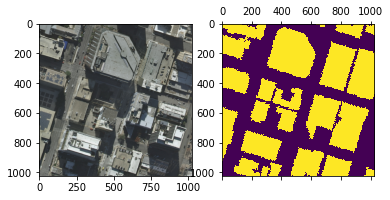

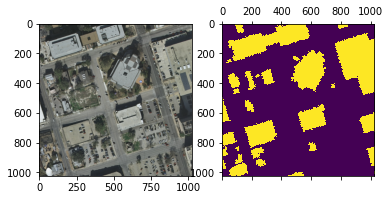

In [42]:
#as an idiot check, lets look at the output of the generator.
#for a full training batch... 

x,y = next(train_generator)
#x,y = next(validation_generator)

for count,(im,lab) in enumerate(zip(x, y)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(im)
    ax2.matshow(lab.squeeze(), vmin = 0, vmax = 1)
#     print(np.amax(lab.squeeze()))
#     print(np.amin(lab.squeeze()))
#     actual_lab = lab.squeeze()
#     print(lab.shape)

In [43]:
#the model
nstrides = (1,1)

#first we define the inputs, which is the shape of images defined in teh code blocks above 
inputs = layers.Input(imshape)

# 'Honey I shrunk the kids"'
# now we set up 4 blocks of comvolutons in the 'encoder' part
#block1
conv01 = layers.Conv2D(32, 4, activation = 'relu', strides = nstrides, padding="same")(inputs)
conv1 = layers.Conv2D(32, 4, activation = 'relu', strides = nstrides, padding="same")(conv01)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#block2
conv02 = layers.Conv2D(64, 4, activation = 'relu', strides = nstrides, padding="same")(pool1)
conv2 = layers.Conv2D(64, 4, activation = 'relu', strides = nstrides, padding="same")(conv02)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#block3
conv03 = layers.Conv2D(128, 4, activation = 'relu', strides = nstrides, padding="same")(pool2)
conv3 = layers.Conv2D(128, 4, activation = 'relu', strides = nstrides, padding="same")(conv03)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

#block4
conv04 = layers.Conv2D(256, 4, activation = 'relu', strides = nstrides, padding="same")(pool3)
conv4 = layers.Conv2D(256, 4, activation = 'relu', strides = nstrides, padding="same")(conv04)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)


# we shrink as far as we are going to go...
#bottlneck
conv05 = layers.Conv2D(512, 4, activation = 'relu', strides = nstrides, padding="same")(pool4)
conv5 = layers.Conv2D(512, 4, activation = 'relu', strides = nstrides, padding="same")(conv05)
upconv5 = layers.Conv2DTranspose(256, kernel_size=(2, 2), strides = (2,2))(conv5)

# 'Honey I blew up the kids"... we upsample now
#upblock 1
conc6 = layers.concatenate([upconv5, conv4])
conv06 = layers.Conv2D(256, 4, activation = 'relu', strides = nstrides, padding="same")(conc6)
conv6 = layers.Conv2D(256, 4, activation = 'relu', strides = nstrides, padding="same")(conv06)
up7 = layers.Conv2DTranspose(126, kernel_size=(2, 2), strides = (2,2))(conv6)

#upblock 2
conc7 = layers.concatenate([up7, conv3])
conv07 = layers.Conv2D(128, 4, activation = 'relu', strides = nstrides, padding="same")(conc7)
conv7 = layers.Conv2D(128, 4, activation = 'relu', strides = nstrides, padding="same")(conv07)
up8 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides = (2,2))(conv7)

#upblock 3
conc8 = layers.concatenate([up8, conv2])
conv08 = layers.Conv2D(64, 4, activation = 'relu', strides = nstrides, padding="same")(conc8)
conv8 = layers.Conv2D(64, 4, activation = 'relu', strides = nstrides, padding="same")(conv08)
up9 = layers.Conv2DTranspose(32, kernel_size=(2, 2), strides = (2,2))(conv8)

#upblock 4
conc9 = layers.concatenate([up9, conv1])
conv09 = layers.Conv2D(32, 4, activation = 'relu', strides = nstrides, padding="same")(conc9)
conv9 = layers.Conv2D(32, 4, activation = 'relu', strides = nstrides, padding="same")(conv09)

#we define the outputs here
outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(conv9)


#combine the model together
model = Model(inputs, outputs)

#and print out the text summary of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_19 (Conv2D)             (None, 1024, 1024,   1568        ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 1024, 1024,   16416       ['conv2d_19[0][0]']              
                                32)                                                         

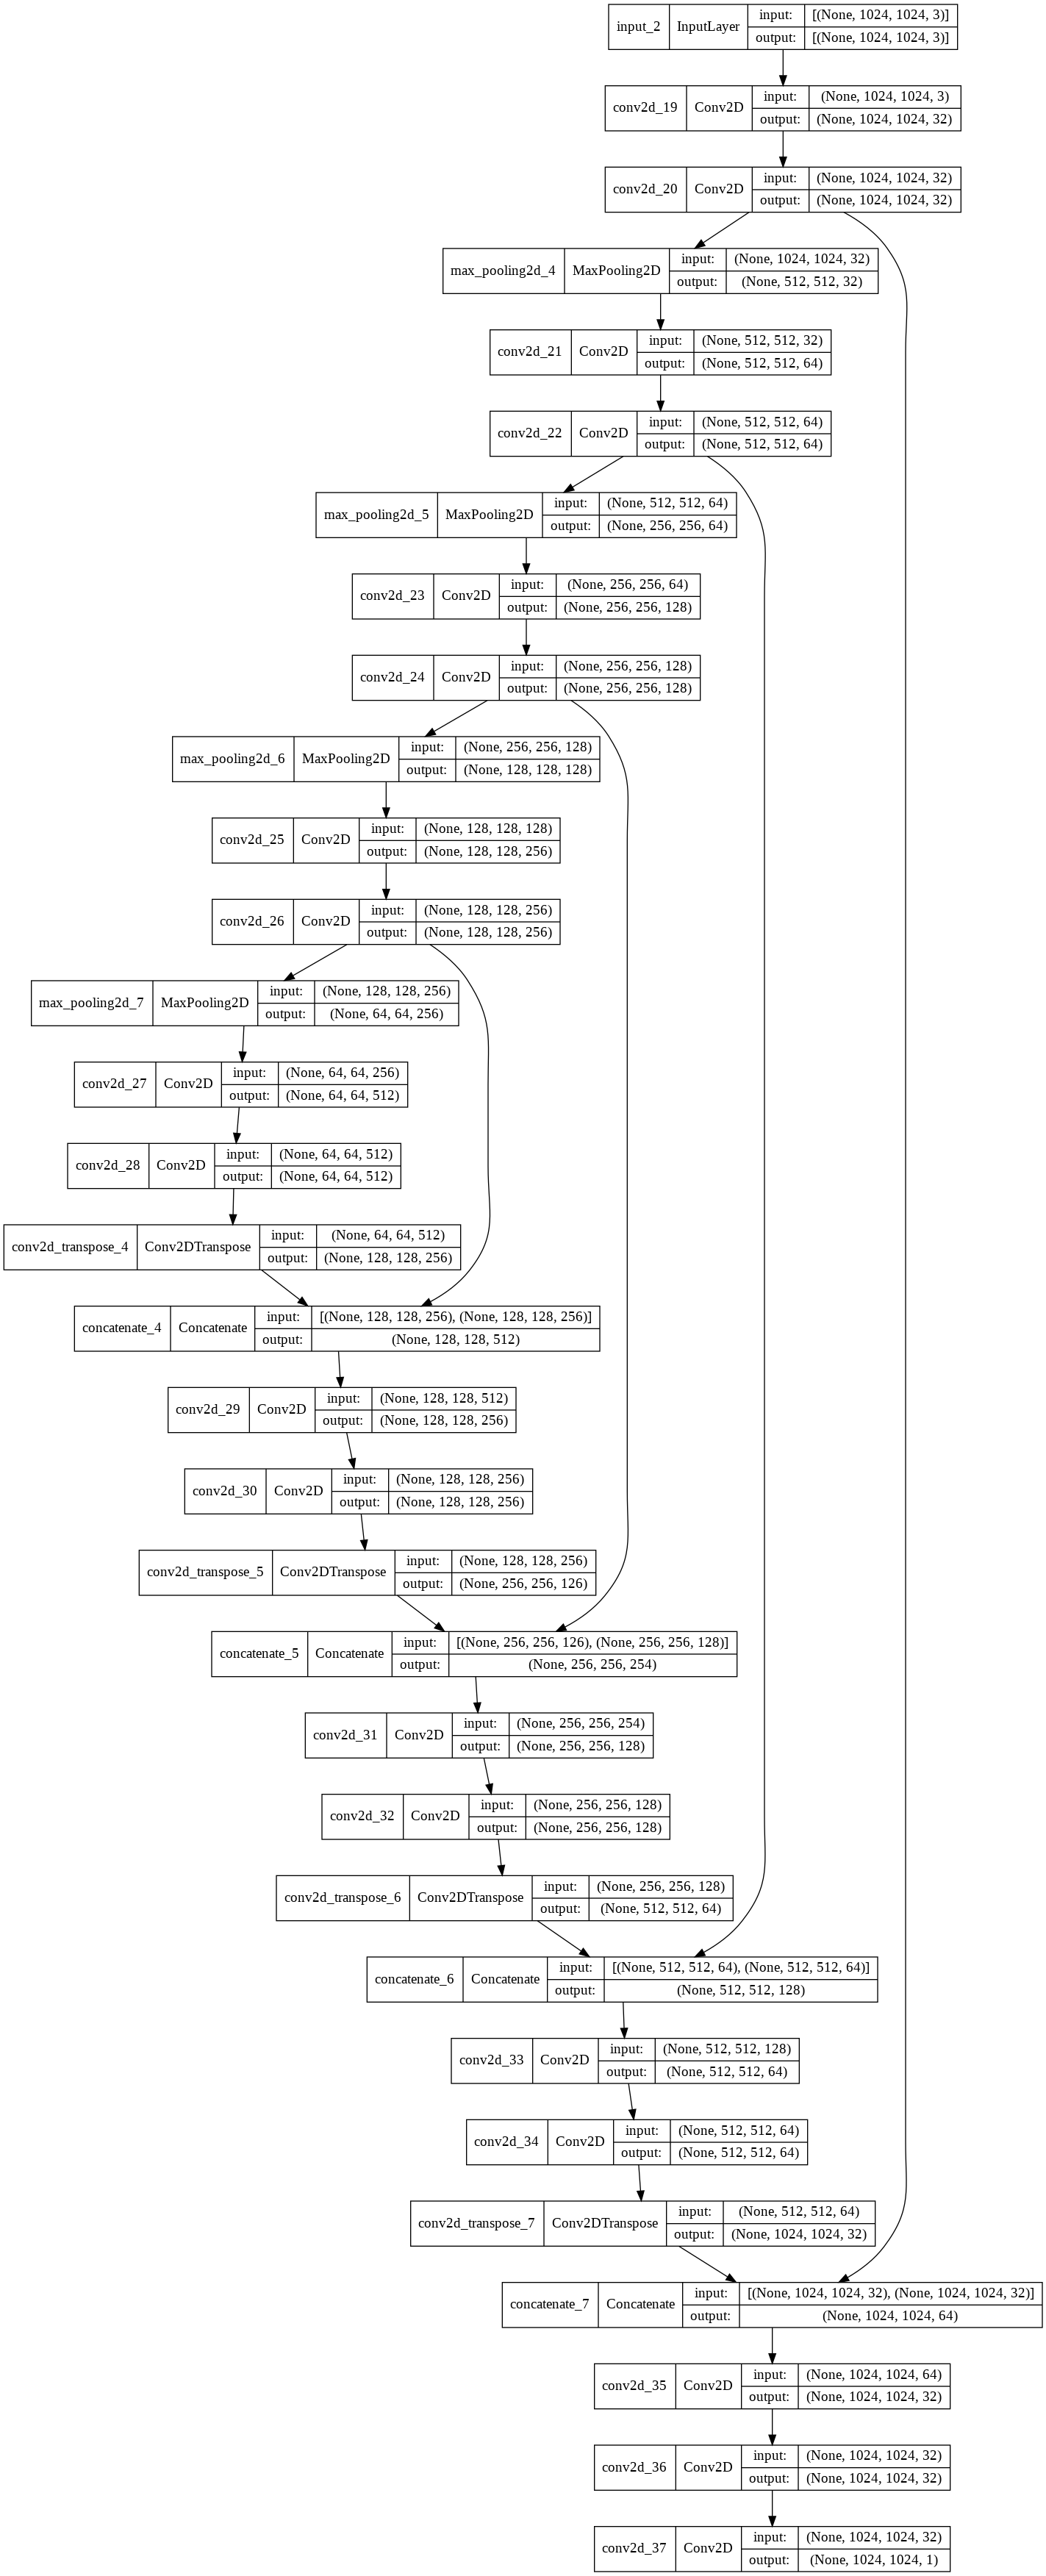

In [44]:
# here is a graphic summary of the model... you can see the downsampling, bottleneck, and upsampling, connected to each other via skip connections
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [45]:
#we compile the model, set a loss function, and also an optimizer. 
model.compile( loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [46]:
# define a callback, which runs during training and does something for us. 
#This one looks at the training loss, and stops the training if the loss does 
#not improve from some number of epochs. Then it reverts to the best version of 
# the model, where loss was lowest

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'loss', 
                                             patience = 10, 
                                             restore_best_weights = True)

In [47]:
#lets now train the model! We can store all teh model output in 'history'.
# note that we are using the training generator for training data, the val 
# generator for validation data, we set the model to train for some number of epochs, 
# we tell teh network how many steps there are to get through the entire data set
# and we also give the network our callback to use.

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 3,
                    workers = 24,
                    steps_per_epoch = total_train // batch_size,
                    validation_steps =  total_val // batch_size,
                    callbacks =[callbacks])

Epoch 1/3
200/200 [==============================] - 786s 4s/step - loss: 0.4946 - binary_accuracy: 0.8151 - val_loss: 0.4635 - val_binary_accuracy: 0.8098
Epoch 2/3
200/200 [==============================] - 775s 4s/step - loss: 0.5195 - binary_accuracy: 0.7730 - val_loss: 14.3359 - val_binary_accuracy: 0.7818
Epoch 3/3
200/200 [==============================] - 759s 4s/step - loss: 0.7389 - binary_accuracy: 0.7747 - val_loss: 0.5005 - val_binary_accuracy: 0.8183


INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets


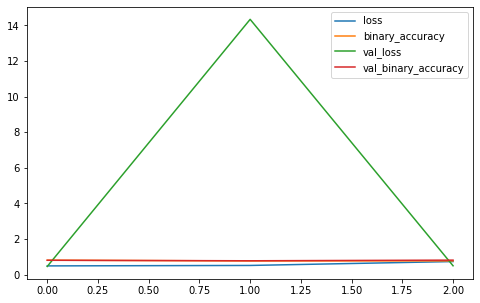

In [48]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
#plt.grid(True)
plt.show


model.save('/content/drive/MyDrive')

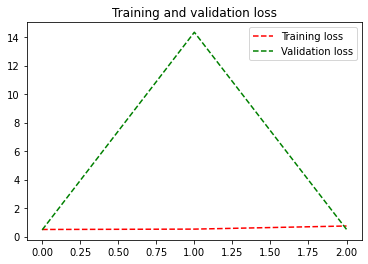

<Figure size 432x288 with 0 Axes>

In [49]:
#now that training is done, lets look at the metrics from training
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'g--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

# # if you have another metric... i.e.,accuracy
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

# plt.title('Training and validation accuracy')
# plt.legend(loc=0)
# plt.figure()
# plt.show()


In [50]:
from PIL import Image

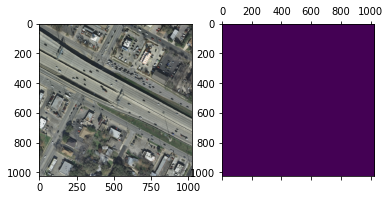

In [51]:
#lets look at the model prediction on a single image.

# here is the gdrive path to the image
imgp = '/content/drive/MyDrive/updated_images/train/images/images/austin1-0.jpg'

#we pull the image and preprocess it — normalizing and making it a array/tensor
img = tf.keras.preprocessing.image.load_img(imgp, target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img = np.expand_dims(img,axis=0)

#We use the model to make a prediction on this image
pred = model.predict(img)

# we use round to get the labels for the image (recall the output of the 
# model is a tensor with shape of the image and then a depth equal to the 
# number of classes. this argmax and squeeze are here to collapse that).


#print(pred.shape)
lab = pred.squeeze()
lab =np.round(pred.squeeze())
#print(lab.shape)

#lets look at the model results and the image

imgUP = matplotlib.image.imread(imgp)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img.squeeze())
labels = ax2.matshow(lab)
#cax = fig.colorbar(labels, ax = ax2)
plt.show()

# non-B: 0; building:1

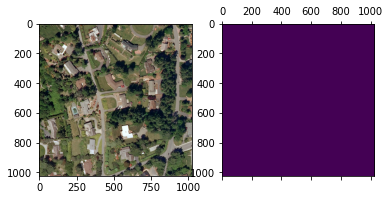

In [52]:
#look at model with a noaa image
imgp = '/content/drive/MyDrive/updated_images/test/images/bellingham1-0.jpg'
imgp = '/content/drive/MyDrive/updated_images/test/images/bellingham1-1.jpg'


#we pull the image and preprocess it — normalizing and making it a array/tensor
img = tf.keras.preprocessing.image.load_img(imgp,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img = np.expand_dims(img,axis=0)

#We use the model to make a prediction on this image
pred = model.predict(img)

# we use round to get the labels for the image (recall the output of the 
# model is a tensor with shape of the image and then a depth equal to the 
# number of classes. this argmax and squeeze are here to collapse that).


#print(pred.shape)
lab = pred.squeeze()
lab =np.round(pred.squeeze())
#print(lab.shape)

#lets look at the model results and the image

imgUP = matplotlib.image.imread(imgp)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img.squeeze())
labels = ax2.matshow(lab)
#cax = fig.colorbar(labels, ax = ax2)
plt.show()

# non-B: 0; building:1